In [4]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torch import nn

# 简单线性回归
受教育年限x与收入数据集y
"" ,  "Education",       "Income"
"1",  10,                26.6588387834389
"2",  10.4013377926421,  27.3064353457772

4.986007213592529 -29.604738235473633


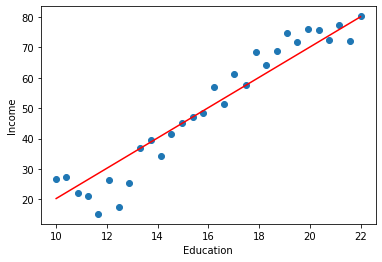

In [73]:
# 数据预处理 values将Series转为numpy.ndarray
data = pd.read_csv('dataset/Income1.csv')  # DataFrame
X = torch.from_numpy(data.Education.values.reshape(-1, 1)).type(torch.float32)
Y = torch.from_numpy(data.Income.values.reshape(-1, 1)).type(torch.float32)

# 创建模型
model = nn.Linear(1, 1)  # 输入1维，输出1维 y=w*x+b
loss_fn = nn.MSELoss()  # 损失函数 均方误差
optim = torch.optim.SGD(model.parameters(), lr=0.001)  # 优化算法 随机梯度下降

# 开始训练
for epoch in range(2000):
    for x, y in zip(X, Y):
        y_pred = model(x)
        loss = loss_fn(y, y_pred)
        optim.zero_grad()  # 梯度归零
        loss.backward()  # 反向传播自动计算梯度
        optim.step()  # update 参数w b

print(model.weight.item(), model.bias.item())

# 绘图可视化
plt.xlabel('Education')
plt.ylabel('Income')
plt.scatter(data.Education, data.Income)
plt.plot(X.numpy(), model(X).data.numpy(), c='r')

## 底层实现

4.983036041259766 -29.539405822753906


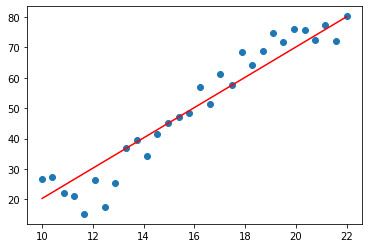

In [72]:
w = torch.randn(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
learning_rate = 0.001
for epoch in range(2000):
    for x, y in zip(X, Y):
        y_pred = torch.matmul(x, w) + b
        loss = (y-y_pred).pow(2).sum()
        if not w.grad is None:
            w.grad.data.zero_()
        if not b.grad is None:
            b.grad.data.zero_()
        loss.backward()
        with torch.no_grad():
            w.data -= w.grad.data*learning_rate
            b.data -= b.grad.data*learning_rate

print(w.item(), b.item())
plt.scatter(data.Education, data.Income)
plt.plot(X.numpy(), (torch.matmul(X, w) + b).data.numpy(), c='r')

# Pytorch语法
## 随机生成张量
同numpy

In [22]:
print("[0,1)均匀分布的随机数\n",torch.rand(2,3))
print("2*3的标准正态分布随机数\n",torch.randn(2,3))
print("全0数组\n", torch.zeros(2,3))
print("全1数组\n", torch.ones(2,3))

[0,1)均匀分布的随机数
 tensor([[0.9485, 0.9842, 0.1609],
        [0.9198, 0.6857, 0.2638]])
2*3的标准正态分布随机数
 tensor([[-0.1790,  2.2180,  1.1524],
        [ 1.0164,  0.3980, -0.2611]])
全0数组
 tensor([[0., 0., 0.],
        [0., 0., 0.]])
全1数组
 tensor([[1., 1., 1.],
        [1., 1., 1.]])


## 数据类型及转换
torch.int16 32 64
torch.float32 64

In [27]:
x = torch.tensor([6,2], dtype=torch.float32)
x.type(torch.int32)  # 类型转换

tensor([6, 2], dtype=torch.int32)

In [32]:
x = torch.from_numpy(np.random.randn(2,3))  # numpy转为tensor
print(x)
x.numpy()  # 转为numpy

tensor([[ 0.3955,  1.3541, -0.2947],
        [ 0.4407,  0.0360, -0.8637]], dtype=torch.float64)


array([[ 0.39547951,  1.35405147, -0.29468327],
       [ 0.44065839,  0.03596732, -0.86366915]])

## 张量运算
同numpy，直接 + - * /


In [42]:
x1 = torch.rand(2,3)   # 均匀分布
x2 = torch.rand(2,3)
x1.add_(x2)  # 加_会直接改变x1

tensor([[0.6261, 0.1251, 0.6799],
        [0.4958, 1.8673, 1.7082]])

In [44]:
x1.view(-1,1)  # 等价于numpy中的reshape(-1,1) 展平 等价于(n,1)

tensor([[0.6261],
        [0.1251],
        [0.6799],
        [0.4958],
        [1.8673],
        [1.7082]])

In [45]:
x1.sum().item()  # 统计方法sum同numpy; item()将tensor变为标量

5.50242805480957

## 张量的自动微分
类似tensorflow中的待优化张量Variable；

将Torch.Tensor属性 .requires_grad 设置为True，pytorch将开始跟踪对此张量的所有操作。
完成计算后，可以调用 .backward() 并自动计算所有梯度。该张量的梯度将累加到.grad属性中。

In [65]:
x = torch.ones(2, 2, requires_grad=True)  # 等价于x.requires_grad_(True)
y = (x + 2) ** 2 * 3  # y具有grad_fn属性，可计算梯度
z = y.mean()
print(y, z)
z.backward()  # 自动微分运算, z是标量值
print(x.grad)  # 打印梯度dz/dx

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


当不需要跟踪计算时，可以通过将代码块包装在with torch.no_grad()上下文中；等价于x.detach()

In [63]:
print((x ** 2).requires_grad)
with torch.no_grad():
    print((x ** 2).requires_grad)
y = (x ** 2).detach()
print(y.requires_grad)

True
False
False


# 二分类 逻辑回归 HR数据集
人力资源数据集：根据各个特征，预测该员工是否会在近期离职；
                                                                                                        离职                       部门
satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,part, salary
   0.38,                 0.53,           2,              157,              3,                 0,         1,          0,            sales,low
   0.8,                  0.86,           5,              262,              6,                 0,         1,          0,            sales,medium

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
%matplotlib inline

## 数据预处理 TensorDataset
是Dataset的子类，已经覆写了__len__(返回数据集大小)和__getitem__(使实例化后的对象支持下标操作)，只要传入张量即可，它通过第一个维度进行索引。

In [11]:
data = pd.read_csv('dataset/HR.csv')
# get_dummies将数据中的英文转为独热编码(如salary变为low medium high 3列)
data = data.join(pd.get_dummies(data.part)).join(pd.get_dummies(data.salary))
data.drop(columns=['part', 'salary'], inplace=True)
X = torch.from_numpy(data[[c for c in data.columns if c != 'left']].values).type(torch.float32)  # Size([14999, 20])
Y = torch.from_numpy(data.left.values.reshape(-1, 1)).type(torch.float32)  # Size([14999, 1])

batch = 512
train_x, test_x, train_y, test_y = train_test_split(X, Y)  # 划分训练集和测试集 默认4:1
train_ds, test_ds = TensorDataset(train_x, train_y), TensorDataset(test_x, test_y)
train_dl, test_dl = DataLoader(train_ds, batch_size=batch, shuffle=True), DataLoader(test_ds, batch_size=batch)

## 创建模型 Class

In [12]:
class Logistic(nn.Module):
    def __init__(self):
        """初始化所有层"""
        super().__init__()
        # 当前层 输入x和输出y的特征维度(20,60)
        self.lin_1 = nn.Linear(20, 64)
        self.lin_2 = nn.Linear(64, 64)
        self.lin_3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()  # 可用F.relu()代替
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        """定义模型的前向传播过程"""
        x = self.relu(self.lin_1(input))
        x = self.relu(self.lin_2(x))
        x = self.sigmoid(self.lin_3(x))
        return x
model = Logistic()

## 损失函数和优化器

In [13]:
loss_fn = torch.nn.BCELoss()  # 交叉熵损失函数
optim = torch.optim.Adam(model.parameters(), lr=0.001)  # 优化器 自动完成参数的初始化操作

## 开始训练

In [14]:
def accuracy(y_pred, y_true):
    """计算正确率"""
    preds = (y_pred > 0.5).type(torch.IntTensor)
    acc = (preds == y_true).float().mean()
    return acc

for epoch in range(100):
    for batch, (x, y) in enumerate(train_dl):
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

    with torch.no_grad():
        epoch_train_accuracy = accuracy(model(train_x), train_y).item()
        epoch_train_loss = loss_fn(model(train_x), train_y).data.item()
        epoch_test_accuracy = accuracy(model(test_x), test_y).item()
        epoch_test_loss = loss_fn(model(test_x), test_y).data.item()
        print('epoch:', epoch,
              'loss:', round(epoch_train_loss, 3), "accuracy", round(epoch_train_accuracy, 3),
              "test_loss", round(epoch_test_loss, 3), "test_accurary", round(epoch_test_accuracy, 3))

epoch: 9 loss: 0.521 accuracy 0.761 test_loss 0.521 test_accurary 0.763
epoch: 19 loss: 0.45 accuracy 0.75 test_loss 0.451 test_accurary 0.752
epoch: 29 loss: 0.403 accuracy 0.813 test_loss 0.405 test_accurary 0.812
epoch: 39 loss: 0.345 accuracy 0.84 test_loss 0.347 test_accurary 0.841
epoch: 49 loss: 0.307 accuracy 0.863 test_loss 0.31 test_accurary 0.861
epoch: 59 loss: 0.285 accuracy 0.889 test_loss 0.29 test_accurary 0.886
epoch: 69 loss: 0.27 accuracy 0.887 test_loss 0.279 test_accurary 0.881
epoch: 79 loss: 0.262 accuracy 0.898 test_loss 0.27 test_accurary 0.896
epoch: 89 loss: 0.254 accuracy 0.899 test_loss 0.268 test_accurary 0.893
epoch: 99 loss: 0.241 accuracy 0.911 test_loss 0.255 test_accurary 0.909


# 多分类问题 鸢尾花数据集
数据集介绍：共有数据150组，每组包括花尊长、花尊宽、花瓣长、花瓣宽4个输入特征。以及这组特征对应的鸢尾花类别。
类别包括(狗尾草鸢尾)(杂色鸢尾)(弗吉尼亚鸢尾)三类，分别用数字0，1，2表示。
"","Sepal.Length","Sepal.Width","Petal.Length","Petal.Width","Species"
"1",    5.1,           3.5,          1.4,         0.2,         "setosa"
"2",    4.9,           3,            1.4,         0.2,         "setosa"

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
%matplotlib inline

## 数据预处理

In [41]:
data = pd.read_csv("dataset/iris.csv")
data['Species'] = pd.factorize(data.Species)[0]  # 将字符串之转为数值类型0 1 2···
X = torch.from_numpy(data.iloc[:, 1: -1].values).type(torch.float32) # (150,4)
Y = torch.from_numpy(data.Species.values).type(torch.int64)  # (150,)  注意输出类型

batch = 8
train_x, test_x, train_y, test_y = train_test_split(X, Y)  # 划分训练集和测试集 默认4:1
train_ds, test_ds = TensorDataset(train_x, train_y), TensorDataset(test_x, test_y)
train_dl, test_dl = DataLoader(train_ds, batch_size=batch, shuffle=True), DataLoader(test_ds, batch_size=batch)

## 创建模型

In [42]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.liner_1 = nn.Linear(4, 32)
        self.liner_2 = nn.Linear(32, 32)
        self.liner_3 = nn.Linear(32, 3)
    def forward(self, input):
        x = F.relu(self.liner_1(input))
        x = F.relu(self.liner_2(x))
        x = self.liner_3(x)  # 因为nn.CrossEntropyLoss()参数是未激活输出，所以这里没激活
        return x
model = Model()

## 损失函数和优化器

In [43]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

## 开始训练

In [44]:
def accuracy(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=1)  # 按(概率)最大值所在位置，转换为实际的预测结果(0 1 2)
    acc = (y_pred == y_true).float().mean()
    return acc

train_loss, train_acc, test_loss, test_acc = [], [], [], []
epochs = 100
for epoch in range(epochs):
    for batch, (x, y) in enumerate(train_dl):
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

    with torch.no_grad():
        epoch_train_accuracy = accuracy(model(train_x), train_y).item()
        epoch_train_loss = loss_fn(model(train_x), train_y).data.item()
        epoch_test_accuracy = accuracy(model(test_x), test_y).item()
        epoch_test_loss = loss_fn(model(test_x), test_y).data.item()
        print('epoch:', epoch,
              'loss:', round(epoch_train_loss, 3), "accuracy", round(epoch_train_accuracy, 3),
              "test_loss", round(epoch_test_loss, 3), "test_accurary", round(epoch_test_accuracy, 3))
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_accuracy)

epoch: 0 loss: 1.241 accuracy 0.018 test_loss 1.155 test_accurary 0.0
epoch: 1 loss: 1.219 accuracy 0.027 test_loss 1.14 test_accurary 0.053
epoch: 2 loss: 1.199 accuracy 0.08 test_loss 1.123 test_accurary 0.158
epoch: 3 loss: 1.18 accuracy 0.161 test_loss 1.108 test_accurary 0.289
epoch: 4 loss: 1.162 accuracy 0.188 test_loss 1.097 test_accurary 0.316
epoch: 5 loss: 1.147 accuracy 0.232 test_loss 1.086 test_accurary 0.316
epoch: 6 loss: 1.132 accuracy 0.241 test_loss 1.077 test_accurary 0.368
epoch: 7 loss: 1.118 accuracy 0.241 test_loss 1.068 test_accurary 0.447
epoch: 8 loss: 1.105 accuracy 0.268 test_loss 1.058 test_accurary 0.474
epoch: 9 loss: 1.093 accuracy 0.286 test_loss 1.05 test_accurary 0.474
epoch: 10 loss: 1.082 accuracy 0.286 test_loss 1.044 test_accurary 0.474
epoch: 11 loss: 1.073 accuracy 0.286 test_loss 1.036 test_accurary 0.474
epoch: 12 loss: 1.063 accuracy 0.286 test_loss 1.031 test_accurary 0.474
epoch: 13 loss: 1.054 accuracy 0.33 test_loss 1.024 test_accurary 0

## 模板 可视化函数

In [66]:
def show_acc(train_loss, test_loss, train_acc, test_acc):
    fig = plt.figure(figsize=(14, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_loss, label='train_loss')
    plt.plot(range(1, epochs+1), test_loss, label='test_loss')
    plt.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_acc, label='train_acc')
    plt.plot(range(1, epochs+1), test_acc, label='test_acc')
    plt.legend()

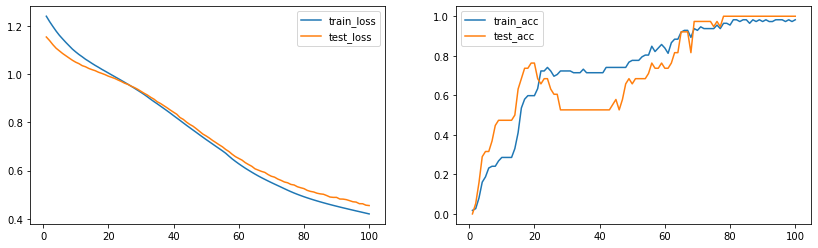

In [46]:
show_acc(train_loss, test_loss, train_acc, test_acc)

## 模板 fit函数

In [67]:
def fit(epoch, model, trainloader, testloader):
    """输入模型、输入数据(train_dl, test_dl)， 对数据输入在模型上训练，并且返回loss和acc变化"""
    correct = 0
    total = 0
    running_loss = 0
    for x, y in trainloader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader.dataset)  # 平均loss
    epoch_acc = correct / total


    test_correct = 0
    test_total = 0
    test_running_loss = 0
    with torch.no_grad():
        for x, y in testloader:
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()

    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total

    print('epoch: ', epoch,
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )

    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

## 将模板应用到手写数字识别

epoch:  0 loss：  0.005 accuracy: 0.903 test_loss：  0.001 test_accuracy: 0.953
epoch:  1 loss：  0.002 accuracy: 0.959 test_loss：  0.0 test_accuracy: 0.963
epoch:  2 loss：  0.001 accuracy: 0.971 test_loss：  0.0 test_accuracy: 0.971
epoch:  3 loss：  0.001 accuracy: 0.978 test_loss：  0.0 test_accuracy: 0.974
epoch:  4 loss：  0.001 accuracy: 0.982 test_loss：  0.0 test_accuracy: 0.976
epoch:  5 loss：  0.001 accuracy: 0.986 test_loss：  0.0 test_accuracy: 0.976
epoch:  6 loss：  0.001 accuracy: 0.988 test_loss：  0.0 test_accuracy: 0.976
epoch:  7 loss：  0.0 accuracy: 0.99 test_loss：  0.0 test_accuracy: 0.977


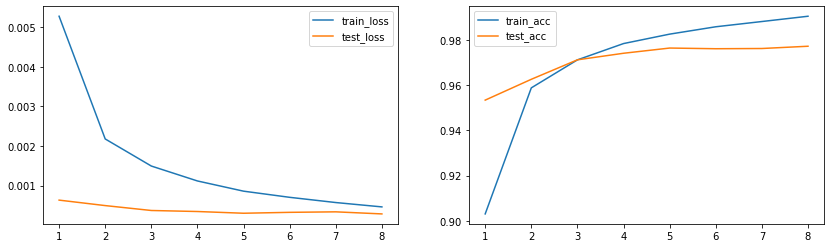

In [69]:
# 数据预处理
from torchvision import datasets, transforms
transformation = transforms.Compose([transforms.ToTensor(),])  # 转化为tensor，归一化 到0-1之间，将channel放在第一维度
train_ds = datasets.MNIST('data/', train=True, transform=transformation, download=False)
test_ds = datasets.MNIST('data/', train=False, transform=transformation, download=False)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=256)

# 创建模型
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.liner_1 = nn.Linear(28*28, 120)
        self.liner_2 = nn.Linear(120, 84)
        self.liner_3 = nn.Linear(84, 10)
    def forward(self, input):
        x = input.view(-1, 28*28)  # 展平
        x = F.relu(self.liner_1(x))
        x = F.relu(self.liner_2(x))
        x = self.liner_3(x)
        return x
model = Model()


# 损失函数和优化器 超参数
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss, train_acc, test_loss, test_acc = [], [], [], []
epochs = 8

# 开始训练
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

show_acc(train_loss, test_loss, train_acc, test_acc)

tensor([5, 3, 0, 8, 3, 4, 6, 4, 9, 0])


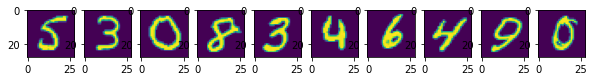

In [65]:
## 看看长什么样
def imshow(img):
    npimg = np.squeeze(img.numpy())  # 删除掉唯一的维度
    plt.imshow(npimg)
imgs, labels = next(iter(train_dl))  # [64, 1, 28, 28] [batch channel height width]
plt.figure(figsize=(10, 1))
for i, img in enumerate(imgs[:10]):
    plt.subplot(1, 10, i+1)
    imshow(img)
print(labels[:10])